In [1]:
import re
import pandas as pd
import numpy as np
from matplotlib.pyplot import *
%matplotlib inline

/Users/jeremy/anaconda/lib/python3.4/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


## Load Fuana Dataset

In [2]:
df = pd.read_csv('../data/fauna.csv.gz', compression='gzip')
df = df.set_index(keys=['page-id'])
df.head()

,class,family,genus,kingdom,order,phylum,species,text,title
page-id,,,,,,,,,
3451749,amphibia,ranidae,rana,animalia,anura,chordata,rboylii,The foothill yellow-legged frog (Rana boylii) ...,Foothill yellow-legged frog
38082824,amphibia,ranidae,lithobates,animalia,anura,chordata,lsylvaticus,This is a redirect from a title with another m...,Wood Frog
1369072,mammalia,bovidae,pantholopshodgson18342,animalia,artiodactyla,chordata,phodgsonii,The Tibetan antelope or chiru (Pantholops hodg...,Tibetan antelope
26625724,mammalia,bovidae,damaliscus,animalia,artiodactyla,chordata,dsuperstes,The Bangweulu tsessebe (Damaliscus superstes) ...,Bangweulu tsessebe
1709509,mammalia,tayassuidae,catagonusameghino1904,animalia,artiodactyla,chordata,cbrachydontuscmetropolitanuscstenocephaluscwag...,The Chacoan peccary or tagua (Catagonus wagner...,Chacoan peccary


## Visualize the number of records in each class

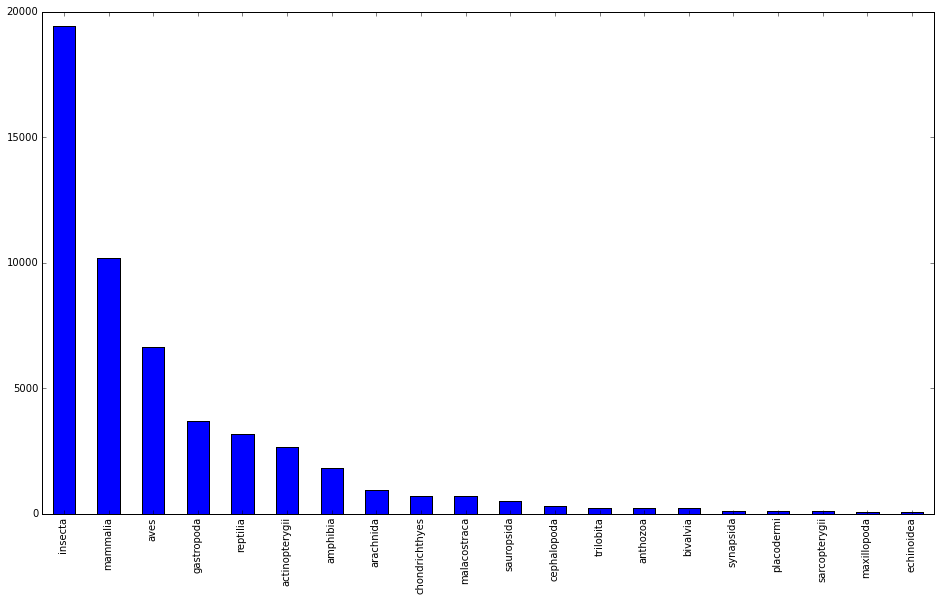

In [3]:
classes = df['class'].value_counts()
figure(figsize=(16, 9))
classes[0:20].plot(kind="bar")

### Create a TFIDF Table

In [31]:
from math import log

count = 0
limit = 3            # limit the number of documents we scan
doc_freq = {}           # doc_freq['word'].add(index)
term_freq = {}          # term_freq[234234] = {'word' : count}
#word_count_history = [] # record the number of unique words in the corpus as we scan through it
for index, row in df[:limit].iterrows():
    if count < limit and row['text'] != '':
        count += 1
        if index in term_freq:
            terms = term_freq[index]
        else:
            terms = term_freq[index] = {}
        
        # find all words, ignore numbers, special characters and new lines/spaces/etc...
        s = str(row['text']).lower()
        word_list = re.findall(r'\b[^\W\d_]+\b', s)
        
        for word in word_list:
            if word in terms:
                terms[word] += 1
            else:
                terms[word] = 1
            '''
            if word in doc_freq:
                doc_freq[word].add(index)
            else:
                doc_freq[word] = set()
                doc_freq[word].add(index)
            '''
        #word_count_history.append(len(doc_freq))

# convert the term frequencies to a DataFrame
tf = pd.DataFrame(term_freq)
tf = tf.fillna(0)
tf = tf.apply(lambda x : x / np.sqrt(np.sum(np.power(x.values, 2)))) # normalize term frequency so that magnitude of vector is 1

# doc_freq is map of words to sets of doc ids, 
# we want to know how many documents each word is present in
# create a map of words to the actual number of documents the word is present in
'''
doc_freq_counts = {}
for word in doc_freq:
    if word not in doc_freq_counts:
        doc_freq_counts[word] = len(doc_freq[word])
'''
#idf = pd.Series(doc_freq_counts)
#idf = idf.apply(lambda x : log(len(doc_freq) / (x)))
idf = tf.astype(bool).sum(axis=1).apply(lambda x : np.log(tf.shape[1] / (1 + x)))
tfidf = pd.DataFrame(tf.values.T * idf.values, index=tf.columns, columns=idf.index)

In [32]:
#tf.astype(bool).sum(axis=1)
#log(10 / 11)
#tf.astype(bool).sum(axis=1)
#tfidf.T.sort_values(by=50625189, ascending=False)
tfidf

,a,abdomens,abilities,ability,able,about,above,absent,academy,access,...,xinjiang,year,yearly,years,yellow,young,zàng,གཙ,ད,藏羚羊
1369072,-0.057239,0.000000,0.000000,0.00000,0.002881,0.0,0.000000,0.000000,0.002881,0.000000,...,0.002881,0.005762,0.005762,0.008644,0.000000,0.0,0.002881,0.002881,0.002881,0.002881
3451749,-0.029534,0.002775,0.002775,0.00555,0.000000,0.0,0.002775,0.002775,0.000000,0.002775,...,0.000000,0.000000,0.000000,0.000000,0.024976,0.0,0.000000,0.000000,0.000000,0.000000
38082824,-0.051855,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000


In [25]:
tfidf.head()

,a,abdomens,abilities,ability,about,above,absent,access,adult,adults,...,western,when,where,which,while,whole,why,with,yellow,young
3451749,-0.07116,-0.004744,-0.004744,-0.009488,-0.028464,-0.004744,-0.004744,-0.004744,-0.009488,-0.009488,...,-0.009488,-0.004744,-0.009488,-0.033208,-0.004744,-0.004744,-0.004744,-0.042696,-0.042696,-0.018976


### Just for fun, how does the number of words increase as we count occurences?

In [28]:
#figure(figsize=(16, 9))
word_count_history

[0]